# Importar bibliotecas básicas

In [75]:
# !pip install scikit-learn
# !pip install sklearn.preprocessing
# !pip install cython
# !pip install --upgrade pip
# !pip install seaborn
# !pip install plotly
# !pip install --upgrade numpy

In [76]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn

# Importar dados

In [77]:

paths = ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv','Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
            'Friday-WorkingHours-Morning.pcap_ISCX.csv','Monday-WorkingHours.pcap_ISCX.csv',
            'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv','Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
            'Tuesday-WorkingHours.pcap_ISCX.csv','Wednesday-workingHours.pcap_ISCX.csv']
dfs = []
data_folder = '/home/andre/unicamp/IC/machine_learning/reinforcement_learning/tabular_data/data/raw_data'
for path in paths:
    dfs.append(pd.read_csv(os.path.join(data_folder,path), encoding='utf-8'))
df = pd.concat(dfs)

In [78]:
df.sample()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
3492,43348,109,2,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

# Tratamento de dados

In [80]:
df = df.sample(2830743)
df.reset_index(drop=True, inplace=True)


In [81]:
#eliminate spaces in column names
df.columns = [col.strip() for col in df.columns]

In [82]:
df['Label'].value_counts()

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [83]:
# Replace inf and -inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow 

## Balancear base de dados

### Filtrar classes muito pequenas e separar base de um ataque

In [85]:
# remove classes with less than 1500 instances
surprise_attacks = df.groupby('Label').filter(lambda x : len(x)<5000)
df = df.groupby('Label').filter(lambda x : len(x)>=5000)

In [87]:
one_attack = df.copy()
one_attack['Label'] = one_attack['Label'].apply(lambda x: 'Attack' if x != 'BENIGN' else 'BENIGN')

### Undersample majority classes

In [88]:
df['Label'].value_counts()

Label
BENIGN              2271320
DoS Hulk             230124
PortScan             158804
DDoS                 128025
DoS GoldenEye         10293
FTP-Patator            7935
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Name: count, dtype: int64

#### Multiple attacks

In [106]:
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import LabelEncoder

X_mul = df.drop('Label', axis=1)
y_mul = df['Label']

# encode labels
le_mul = LabelEncoder()
y_mul = le_mul.fit_transform(y_mul)


In [107]:
le_mul.classes_

array(['BENIGN', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
       'DoS slowloris', 'FTP-Patator', 'PortScan', 'SSH-Patator'],
      dtype=object)

In [108]:
# define the number of samples to keep for each class
sampling_strategy = {0: 10000, 1: 10000, 2: 10000, 3:10000, 4:len(y_mul[y_mul==4]), 5:len(y_mul[y_mul==5]), 6:len(y_mul[y_mul==6]), 7: 10000, 8:len(y_mul[y_mul==8])}  # Keep 5000 samples of Benign class

# Apply NearMiss to the majority classes
nm = NearMiss(sampling_strategy=sampling_strategy)
X_res_mul, y_res_mul = nm.fit_resample(X_mul, y_mul)

#### One attack

In [109]:
X_one = one_attack.drop('Label', axis=1)
y_one = one_attack['Label']

# encode labels
le_one = LabelEncoder()
y_one = le_one.fit_transform(y_one)


In [110]:
le_one.classes_

array(['Attack', 'BENIGN', nan], dtype=object)

In [111]:
from imblearn.under_sampling import RandomUnderSampler
# acredito nao fazer sentido usar o NearMiss para o one attack, pois os ataques são variados e não será possível encontrar uma forma de reduzir a quantidade de ataques por estratégias de vizinho mais próximo
# define the number of samples to keep for each class
sampling_strategy = {0: 45000, 1: 45000}
# Apply UnderSample to the majority classes
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res_one, y_res_one = rus.fit_resample(X_one, y_one)

### Oversample minority classes

In [112]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_res_mul, y_res_mul = smote.fit_resample(X_res_mul, y_res_mul)

#### Convert data back into dataframes

In [113]:
# Convert resampled data back to DataFrame
X_res_mul = pd.DataFrame(X_res_mul, columns=X_mul.columns)
y_res_mul = pd.Series(y_res_mul)

# Decode labels
y_res_mul = pd.Series(le_mul.inverse_transform(y_res_mul))

# Combine resampled features and labels
multiple_attacks = pd.concat([X_res_mul, y_res_mul.rename('Label')], axis=1)

# Display the first few rows of the new DataFrame
multiple_attacks.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,63123466,7,0,0,0,0,0,0.0,0.0,...,40,7011966.0,0.0,7011966,7011966,18700000.0,12200000.0,32100000,8015933,BENIGN
1,80,63100251,7,0,0,0,0,0,0.0,0.0,...,40,7004721.0,0.0,7004721,7004721,18700000.0,12200000.0,32100000,8015932,BENIGN
2,80,63124098,7,0,0,0,0,0,0.0,0.0,...,40,7012598.0,0.0,7012598,7012598,18700000.0,12200000.0,32100000,8015932,BENIGN
3,80,63103844,7,0,0,0,0,0,0.0,0.0,...,40,7008302.0,0.0,7008302,7008302,18700000.0,12200000.0,32100000,8015928,BENIGN
4,80,63101726,7,0,0,0,0,0,0.0,0.0,...,40,7006190.0,0.0,7006190,7006190,18700000.0,12200000.0,32100000,8015934,BENIGN


In [114]:
# Convert resampled data back to DataFrame
X_res_one = pd.DataFrame(X_res_one, columns=X_one.columns)
y_res_one = pd.Series(y_res_one)

# Decode labels
y_res_one = pd.Series(le_one.inverse_transform(y_res_one))

# Combine resampled features and labels
one_attack = pd.concat([X_res_one, y_res_one.rename('Label')], axis=1)

# Display the first few rows of the new DataFrame
one_attack.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
43617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attack
38441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attack
13817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attack
15746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attack
14611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attack


In [63]:
print(multiple_attacks['Label'].value_counts(),one_attack['Label'].value_counts())

Label
BENIGN    2271320
Attack     552373
Name: count, dtype: int64

In [26]:
df_resampled = df_resampled.sample(90000)
df_resampled.reset_index(drop=True, inplace=True)

In [34]:
one_attack_train = one.iloc[0:33000].copy()
one_attack_test = df_resampled.iloc[33000:45000].copy()
multiple_attacks_train = df_resampled.iloc[45000:78000].copy()
multiple_attacks_val = df_resampled.iloc[78000:90000].copy()

one_attack_train.reset_index(drop=True, inplace=True)
one_attack_test.reset_index(drop=True, inplace=True)
multiple_attacks_train.reset_index(drop=True, inplace=True)
multiple_attacks_val.reset_index(drop=True, inplace=True)

In [38]:
# #check what are the categories in the column ' Label' and how many instances are there for each category
one_attack_train['Label'].value_counts()
# one_attack_test['Label'].value_counts()
# # multiple_attacks_train['Label'].value_counts()
# # multiple_attacks_val['Label'].value_counts()

Label
DoS GoldenEye       3705
FTP-Patator         3692
DoS Slowhttptest    3683
DoS Hulk            3672
DDoS                3668
PortScan            3665
BENIGN              3653
SSH-Patator         3650
DoS slowloris       3612
Name: count, dtype: int64

# Divisão entre previsores e classe

In [39]:
print(one_attack_train['Label'].value_counts(), one_attack_test['Label'].value_counts())

Label
DoS GoldenEye       3705
FTP-Patator         3692
DoS Slowhttptest    3683
DoS Hulk            3672
DDoS                3668
PortScan            3665
BENIGN              3653
SSH-Patator         3650
DoS slowloris       3612
Name: count, dtype: int64 Label
DDoS                1375
DoS slowloris       1367
SSH-Patator         1358
DoS Slowhttptest    1352
FTP-Patator         1340
BENIGN              1316
DoS Hulk            1306
DoS GoldenEye       1298
PortScan            1288
Name: count, dtype: int64


In [41]:
print(one_attack_train['Label'].value_counts(), one_attack_test['Label'].value_counts())

Label
Attack    29347
BENIGN     3653
Name: count, dtype: int64 Label
Attack    10684
BENIGN     1316
Name: count, dtype: int64


In [16]:
print(multiple_attacks_train['Label'].value_counts(), multiple_attacks_val['Label'].value_counts())

Label
BENIGN                        561717
DoS Hulk                       56972
PortScan                       39299
DDoS                           31587
DoS GoldenEye                   2507
FTP-Patator                     1892
SSH-Patator                     1436
DoS slowloris                   1436
DoS Slowhttptest                1366
Bot                              486
Web Attack � Brute Force         378
Web Attack � XSS                 162
Infiltration                      11
Web Attack � Sql Injection         6
Heartbleed                         2
Name: count, dtype: int64 Label
BENIGN                        561646
DoS Hulk                       56759
PortScan                       39396
DDoS                           31706
DoS GoldenEye                   2572
FTP-Patator                     1990
SSH-Patator                     1476
DoS slowloris                   1402
DoS Slowhttptest                1297
Bot                              489
Web Attack � Brute Force         373


In [17]:
from sklearn.preprocessing import LabelEncoder
data = [one_attack_train, one_attack_test, multiple_attacks_train, multiple_attacks_val]
atributo = 'Label'
for d in data:
    le = LabelEncoder()
    d[atributo] = le.fit_transform(d[atributo].values)        

In [18]:
print(multiple_attacks_train['Label'].value_counts(), multiple_attacks_val['Label'].value_counts())

Label
0     561717
4      56972
10     39299
2      31587
3       2507
7       1892
11      1436
6       1436
5       1366
1        486
12       378
14       162
9         11
13         6
8          2
Name: count, dtype: int64 Label
0     561646
4      56759
10     39396
2      31706
3       2572
7       1990
11      1476
6       1402
5       1297
1        489
12       373
14       146
9         11
13         5
8          2
Name: count, dtype: int64


In [19]:
print(one_attack_train['Label'].value_counts(), one_attack_test['Label'].value_counts())

Label
1    561544
0    137751
Name: count, dtype: int64 Label
1    561754
0    137580
Name: count, dtype: int64


In [20]:
one_attack_train_y = one_attack_train['Label']
one_attack_train_x = one_attack_train.drop('Label', axis=1)
one_attack_test_y = one_attack_test['Label']
one_attack_test_x = one_attack_test.drop('Label', axis=1)
multiple_attacks_train_y = multiple_attacks_train['Label']
multiple_attacks_train_x = multiple_attacks_train.drop('Label', axis=1)
multiple_attacks_val_y = multiple_attacks_val['Label']
multiple_attacks_val_x = multiple_attacks_val.drop('Label', axis=1)

# Normalização

In [21]:
from sklearn.preprocessing import MinMaxScaler


minmax_scaler        = MinMaxScaler()
x_norm               = minmax_scaler.fit_transform(one_attack_train_x)
one_attack_train_x        = pd.DataFrame(x_norm)
x_norm               = minmax_scaler.fit_transform(one_attack_test_x)
one_attack_test_x         = pd.DataFrame(x_norm)
x_norm               = minmax_scaler.fit_transform(multiple_attacks_train_x)
multiple_attacks_train_x     = pd.DataFrame(x_norm)
x_norm               = minmax_scaler.fit_transform(multiple_attacks_val_x)
multiple_attacks_val_x      = pd.DataFrame(x_norm)

# PCA - redução de dimensões

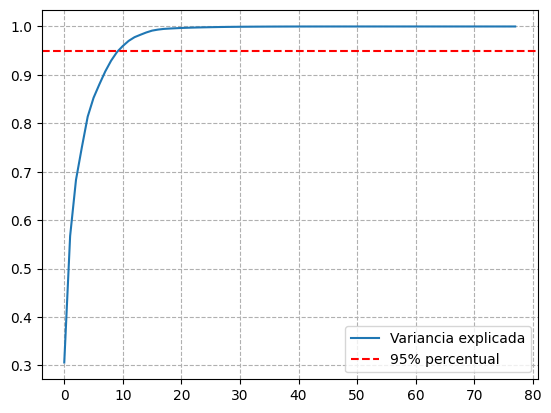

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA().fit(multiple_attacks_val_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Variancia explicada')
plt.axhline(0.95,color='red',linestyle='--',label='95% percentual')
plt.grid(True, linestyle='--')
plt.legend()

In [23]:
to_pca = [one_attack_train_x, one_attack_test_x, multiple_attacks_train_x, multiple_attacks_val_x]
to_df = []
for df in to_pca:
    pca       = PCA(n_components=15)
    dados_pca = pca.fit_transform(df)
    to_df.append(pd.DataFrame(dados_pca))
    # df.head()
    # sns.scatterplot(x=dados_pca[:,0],y=dados_pca[:,1],hue=Y)
to_df.append(one_attack_train_y)
to_df.append(one_attack_test_y)
to_df.append(multiple_attacks_train_y)
to_df.append(multiple_attacks_val_y)

# Ajustar formatos

In [24]:
to_float32 = []
for df in to_df:
    to_float32.append(pd.DataFrame(df))


In [25]:
# Convert only float64 columns to float32
to_save = []
for df in to_float32:
    to_save.append(df.apply(lambda x: x.astype('float32') if x.dtype == 'float64' or x.dtype == 'int64' else x))


# Salvar bases de dados

In [26]:
## aqui não vale a pena dropar as linhas duplicadas, pois droparíamos as duplicadas no x e perderíamos a referência do y
# data = data.drop_duplicates()

In [27]:
name = ['one_attack_train_x', 'one_attack_test_x', 'multiple_attacks_train_x', 'multiple_attacks_val_x', 'one_attack_train_y', 'one_attack_test_y', 'multiple_attacks_train_y', 'multiple_attacks_val_y']
for df,i in zip(to_save,range(len(to_save))):
    df.to_csv(name[i], index=False)

In [28]:
to_save[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.091881,-0.849138,0.531572,0.212544,0.093026,-0.146420,-0.182517,0.316584,0.380575,0.385790,0.003258,-0.077493,0.012072,-0.013187,0.001282
1,-0.507511,0.680919,0.276441,0.008692,-0.040933,-0.024220,-0.252700,-0.501345,0.055043,0.175326,0.068918,-0.063582,0.008437,-0.004752,-0.133099
2,-0.272195,-0.165009,-0.445929,0.004244,-0.012879,0.032111,0.066749,0.005908,-0.044491,0.070965,-0.023524,-0.003529,-0.014284,-0.007183,-0.001867
3,-0.278055,-0.164874,-0.446445,-0.007696,-0.015261,0.027579,0.059936,0.007146,-0.044719,0.067309,-0.026148,-0.004938,-0.015600,-0.004263,-0.001319
4,0.120337,-0.693644,0.283444,0.180019,0.047829,0.027468,-0.096326,0.025876,-0.127451,-0.169511,0.005223,-0.036941,0.015475,-0.011967,-0.021413
